# W2_Logistic Regression with L2 Regularization

In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('amazon_baby_subset.csv')

# perform text cleaning
data = data.fillna({'review':''})
def remove_punctuation(text):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    return text.translate(table)

data['cleaned_review'] = data['review'].apply(remove_punctuation)
data.head()

,name,review,rating,sentiment,cleaned_review
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


In [3]:
important_words = list(pd.read_json('important_words.json')[0]) #193 words
important_words[:5]

['baby', 'one', 'great', 'love', 'use']

In [4]:
for word in important_words:
    data[word] = data['cleaned_review'].apply(lambda s: s.split().count(word))
data.head(1)

,name,review,rating,sentiment,cleaned_review,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# import train data and validation data
train_index = list(pd.read_json('module-4-assignment-train-idx.json')[0])
val_index = list(pd.read_json('module-4-assignment-validation-idx.json')[0])
print('# training data:', len(train_index))
print('# validation data:', len(val_index))
train = data.iloc[train_index]
val = data.iloc[val_index]

# training data: 42361
# validation data: 10711


In [6]:
# convert data frame to multi-dimensional array
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    feature_matrix = dataframe[features].values
    label_array = dataframe[label].values
    return(feature_matrix, label_array)

train_feature_matrix, train_label = get_numpy_data(train, important_words, 'sentiment')
val_feature_matrix, val_label = get_numpy_data(val, important_words, 'sentiment')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
train_feature_matrix.shape

(42361, 194)

In [8]:
# estimate conditional probability with link function
def predict_probability(feature_matrix, coef):
    score = np.dot(feature_matrix, coef)
    prob_predictions = 1 / (1 + np.exp(-score))
    return prob_predictions

In [9]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, is_constant):
    if is_constant == False:
        derivative = np.dot(errors, feature) - 2 * l2_penalty * coefficient
    else:
        derivative = np.dot(errors, feature) # don't regularize intercept term
    return derivative

In [10]:
def compute_log_likelihood_with_L2(feature_matrix, output_array, coef, l2_penalty):
    indicator = (output_array == 1)
    scores = np.dot(feature_matrix, coef)
    lp = np.sum((indicator - 1) * scores - np.log(1. + np.exp(-scores))) - l2_penalty * np.sum(coefficients[1:] ** 2)
    return lp

In [11]:
def logistic_regression_with_L2(feature_matrix, label_array, init_coef, step_size, l2_penalty, max_iter):
    coef = init_coef
    indicator = (label_array==1)
    itr = 0
    
    while itr < max_iter:
        prob_predictions = predict_probability(feature_matrix, coef)
        errors = indicator - prob_predictions
        for index in range(len(init_coef)):
            is_constant = (index == 0)
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,index], coef[index], l2_penalty, is_constant)
            coef[index] = coef[index] + step_size * derivative
        itr += 1
        
    return coef

In [12]:
# explore effects of L2 regularization using different l2 penalties
coef_penalty_0 = logistic_regression_with_L2(train_feature_matrix, train_label, np.zeros(194), 5e-6, 0, 501)
coef_penalty_4 = logistic_regression_with_L2(train_feature_matrix, train_label, np.zeros(194), 5e-6, 4, 501)
coef_penalty_10 = logistic_regression_with_L2(train_feature_matrix, train_label, np.zeros(194), 5e-6, 10, 501)
coef_penalty_1e2= logistic_regression_with_L2(train_feature_matrix, train_label, np.zeros(194), 5e-6, 1e2, 501)
coef_penalty_1e3 = logistic_regression_with_L2(train_feature_matrix, train_label, np.zeros(194), 5e-6, 1e3, 501)
coef_penalty_1e5 = logistic_regression_with_L2(train_feature_matrix, train_label, np.zeros(194), 5e-6, 1e5, 501)

In [13]:
# coef_dict = dict.fromkeys([0, 4, 10, 1e2, 1e3, 1e5])
# for key in coef_dict.keys():
#    coef_dict[key] = logistic_regression_with_L2(train_feature_matrix, train_label, np.zeros(194), key, 0, 501)

In [14]:
coef_df = pd.DataFrame(data=[coef_penalty_0[1:], coef_penalty_4[1:], coef_penalty_10[1:], coef_penalty_1e2[1:], coef_penalty_1e3[1:], coef_penalty_1e5[1:]], columns=important_words, index=['p=0','p=4','p=10','p=100', 'p=1000', 'p=1000000'])
coef_df

,baby,one,great,love,use,would,like,easy,little,seat,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
p=0,0.074073,0.012753,0.801625,1.058554,-0.000104,-0.287021,-0.003384,0.984559,0.524419,-0.086968,...,0.058308,-0.196906,-0.277845,0.173191,-0.132197,0.052494,0.004960,-0.166745,-0.031916,-0.228852
p=4,0.073994,0.012495,0.796897,1.050856,0.000163,-0.286027,-0.003442,0.977600,0.521385,-0.086125,...,0.057905,-0.195273,-0.275461,0.171640,-0.131083,0.052130,0.004907,-0.165367,-0.031621,-0.226793
p=10,0.073877,0.012115,0.789935,1.039529,0.000556,-0.284564,-0.003527,0.967362,0.516917,-0.084883,...,0.057312,-0.192866,-0.271947,0.169352,-0.129441,0.051594,0.004830,-0.163338,-0.031186,-0.223758
p=100,0.072360,0.007247,0.701425,0.896644,0.005481,-0.265993,-0.004635,0.838245,0.460235,-0.069109,...,0.049753,-0.162143,-0.227098,0.140022,-0.108471,0.044805,0.003848,-0.137693,-0.025604,-0.184986
p=1000,0.059752,-0.008761,0.376012,0.418354,0.017326,-0.188662,-0.007043,0.401904,0.251221,-0.017718,...,0.022875,-0.061171,-0.081775,0.044374,-0.040331,0.021026,0.001084,-0.054778,-0.007361,-0.061138
p=1000000,0.001784,-0.001827,0.008950,0.009042,0.000418,-0.008127,-0.000827,0.008808,0.005941,0.000611,...,0.000329,-0.001151,-0.001421,0.000468,-0.000792,0.000365,0.000017,-0.000936,-0.000125,-0.000980


In [15]:
positive_words = list(coef_df.loc['p=0'].sort_values(ascending=False)[:5].index)
negative_words = list(coef_df.loc['p=0'].sort_values()[:5].index)
print('positive words:', positive_words)
print('negative words:', negative_words)

positive words: ['love', 'loves', 'easy', 'perfect', 'great']
negative words: ['disappointed', 'money', 'return', 'waste', 'returned']


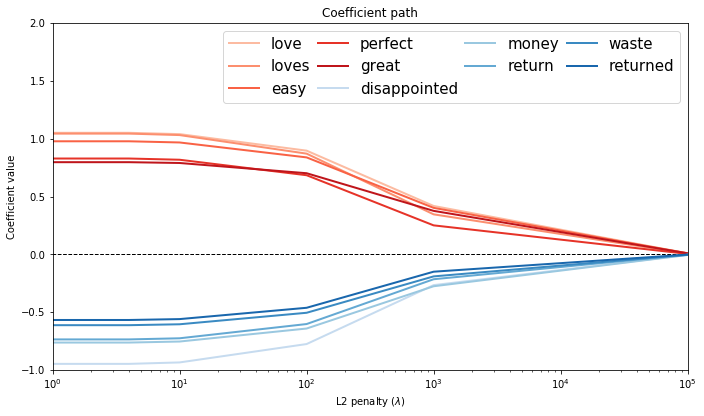

In [16]:
plt.rcParams['figure.figsize'] = (10, 6)

cmap_positive = plt.get_cmap('Reds')
cmap_negative = plt.get_cmap('Blues')

l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5]
plt.plot(l2_penalty_list, [0.]*len(l2_penalty_list), '--', lw=1, color='k')

for i in range(len(positive_words)):
    color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
    plt.plot(l2_penalty_list, coef_df[positive_words[i]], '-', label=positive_words[i], linewidth=2, color=color)
    
for i in range(len(negative_words)):
    color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
    plt.plot(l2_penalty_list, coef_df[negative_words[i]], '-', label=negative_words[i], linewidth=2, color=color)
    
plt.legend(loc='best', ncol=4, prop={'size':15}, columnspacing=0.5)
plt.axis([1, 1e5, -1, 2])
plt.title('Coefficient path')
plt.xlabel('L2 penalty ($\lambda$)')
plt.ylabel('Coefficient value')
plt.xscale('log')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

In [17]:
# measure accuracy 
def compute_acc(feature_matrix, coef, label_array):
    score = np.dot(feature_matrix, coef)
    v_fun = np.vectorize(lambda x: 1 if x>=0 else -1)
    estimated_label = v_fun(score)
    accuracy = sum(estimated_label==label_array) / len(label_array)
    return accuracy

In [18]:
print('accuracy on testing data')
acc_list = []
for coef in [coef_penalty_0, coef_penalty_4, coef_penalty_10, coef_penalty_1e2, coef_penalty_1e3, coef_penalty_1e5]:
    acc_list.append(round(compute_acc(train_feature_matrix, coef, train_label), 5))
acc_df = pd.DataFrame(data=[l2_penalty_list, acc_list], index=[['penalty', 'accuracy']])
acc_df

accuracy on testing data


,0,1,2,3,4,5
penalty,0.00000,4.00000,10.00000,100.00000,1000.00000,100000.00000
accuracy,0.78516,0.78511,0.78499,0.78398,0.77586,0.68037


In [19]:
print('accuracy on validation data')
acc_list = []
for coef in [coef_penalty_0, coef_penalty_4, coef_penalty_10, coef_penalty_1e2, coef_penalty_1e3, coef_penalty_1e5]:
    acc_list.append(round(compute_acc(val_feature_matrix, coef, val_label), 5))
acc_df = pd.DataFrame(data=[l2_penalty_list, acc_list], index=[['penalty', 'accuracy']])
acc_df

accuracy on validation data


,0,1,2,3,4,5
penalty,0.00000,4.00000,10.00000,100.00000,1000.00000,100000.00000
accuracy,0.78144,0.78153,0.78172,0.78107,0.77136,0.66782
